In [ ]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.3/932.3 kB 40.8 MB/s eta 0:00:00


In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import networkx as nx
from collections import Counter
import gc
from prophet import Prophet

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00


# Read in Data

In [ ]:
df_filled_oct = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv')

df_filled_nov = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv')

In [ ]:
full_df = pd.concat([df_filled_oct,df_filled_nov]).reset_index(drop=True)

## Sampled data

In [ ]:
# 1. First, sample the data to make it manageable
print("Sampling data to make it manageable...")
# Sample 5% of users to reduce dataset size
sample_users = np.random.choice(
    df_filled_oct['user_id'].unique(),
    size=int(0.05 * df_filled_oct['user_id'].nunique()),
    replace=False
)

# Filter datasets to only include these users
df_oct_sample = df_filled_oct[df_filled_oct['user_id'].isin(sample_users)]
df_nov_sample = df_filled_nov[df_filled_nov['user_id'].isin(sample_users)]

# Combine the sampled datasets
df_combined = pd.concat([df_oct_sample, df_nov_sample]).reset_index(drop=True)

# Print size of sampled dataset
print(f"Original size: Oct={df_filled_oct.shape}, Nov={df_filled_nov.shape}")
print(f"Sampled size: Combined={df_combined.shape}")

# Free up memory
del df_oct_sample, df_nov_sample
gc.collect()

Sampling data to make it manageable...
Original size: Oct=(42448762, 9), Nov=(67501969, 9)
Sampled size: Combined=(4221048, 9)


60

# Journey Visualizations

In [ ]:
import plotly.graph_objects as go


df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])
df = df_combined.sort_values(by=['user_id', 'product_id', 'event_time'])


# Build the journey table
journeys = []
grouped = df.groupby(['user_id', 'product_id'])


for (user_id, product_id), group in grouped:
   first_view = group.loc[group['event_type'] == 'view', 'event_time'].min()
   first_cart = group.loc[group['event_type'] == 'cart', 'event_time'].min()
   purchase_time = group.loc[group['event_type'] == 'purchase', 'event_time'].min()

   abandoned_cart = pd.notnull(first_cart) and pd.isnull(purchase_time)

   journeys.append({
       'user_id': user_id,
       'product_id': product_id,
       'first_view': first_view,
       'first_cart': first_cart,
       'purchase_time': purchase_time,
       'abandoned_cart': abandoned_cart
   })


journey_df = pd.DataFrame(journeys)


# Count stages
total_views = journey_df['first_view'].notnull().sum()
total_carts = journey_df['first_cart'].notnull().sum()
total_purchases = journey_df['purchase_time'].notnull().sum()
total_abandoned = journey_df['abandoned_cart'].sum()


# Sankey setup
labels = ["Viewed", "Added to Cart", "Purchased", "Abandoned"]
sources = [0, 1, 1]
targets = [1, 2, 3]
values = [total_carts, total_purchases, total_abandoned]

labels = [
    f"Viewed ({values[0]})",
    f"Added to Cart ({values[1] + values[2]})",
    f"Purchased ({values[1]})",
    f"Abandoned ({values[2]})"
]

# Plot
fig = go.Figure(data=[go.Sankey(
   node=dict(
       pad=15, thickness=20, line=dict(color="black", width=0.5),
       label=labels
   ),
   link=dict(
       source=sources,
       target=targets,
       value=values
   )
)])


fig.update_layout(title_text="Customer Journey Funnel", font_size=12)
fig.show()

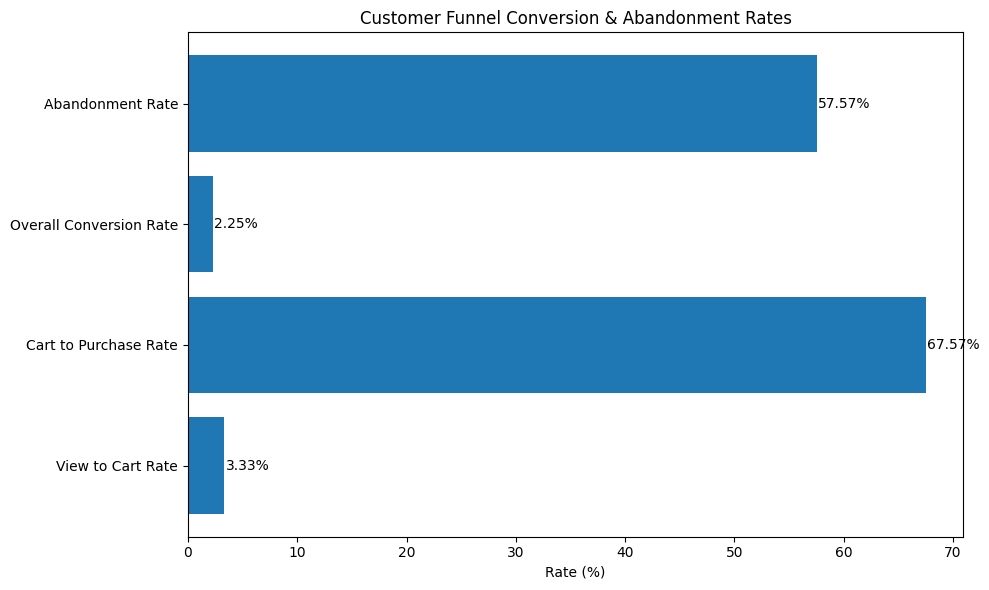

In [ ]:
# Provided metrics
views = total_views
carts = total_carts
purchases = total_purchases
abandoned = total_abandoned


# Calculated rates
view_to_cart_rate = carts / views
cart_to_purchase_rate = purchases / carts
view_to_purchase_rate = purchases / views
abandonment_rate = abandoned / carts


# Display rates
metrics = {
   "View to Cart Rate": view_to_cart_rate,
   "Cart to Purchase Rate": cart_to_purchase_rate,
   "Overall Conversion Rate": view_to_purchase_rate,
   "Abandonment Rate": abandonment_rate
}


# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(metrics.keys()), [v * 100 for v in metrics.values()])
ax.set_xlabel("Rate (%)")
ax.set_title("Customer Funnel Conversion & Abandonment Rates")


# Add percentage labels
for i, v in enumerate(metrics.values()):
   ax.text(v * 100 + 0.1, i, f"{v*100:.2f}%", va='center')


plt.tight_layout()
plt.savefig('conversion_abandonment_rates.png')
plt.show()


In [ ]:
plt.savefig('conversion_abandonment_rates.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
import plotly.express as px


# Convert to datetime if not already
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])
df = df_combined.sort_values(by=['user_id', 'product_id', 'event_time'])


# Create event timeline records
records = []
for (user_id, product_id), group in df.groupby(['user_id', 'product_id']):
   journey_id = f"{user_id} | {product_id}"

   for i in range(len(group) - 1):
       current_event = group.iloc[i]
       next_event = group.iloc[i + 1]

       records.append({
           "journey": journey_id,
           "event_type": current_event["event_type"],
           "start_time": current_event["event_time"],
           "end_time": next_event["event_time"]
       })


# Handle last event as a point-in-time
last_rows = df.groupby(['user_id', 'product_id']).tail(1)
for _, row in last_rows.iterrows():
   records.append({
       "journey": f"{row['user_id']} | {row['product_id']}",
       "event_type": row['event_type'],
       "start_time": row['event_time'],
       "end_time": row['event_time']  # same for a dot-like marker
   })


timeline_df = pd.DataFrame(records)


# Plot Gantt-style timeline
fig = px.timeline(
    timeline_df.head(100),  # Just a small slice
    x_start="start_time",
    x_end="end_time",
    y="journey",
    color="event_type",
    title="Customer Product Journey Timeline",
    labels={"journey": "User | Product"}
)


fig.update_yaxes(autorange="reversed")  # optional: reverse to match Gantt convention
fig.update_layout(height=800)
fig.show()

In [ ]:
# Convert to datetime
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])
df = df_combined.sort_values(by=['user_id', 'product_id', 'event_time'])

# ✅ Filter to only users who purchased
purchased_pairs = df[df['event_type'] == 'purchase'][['user_id', 'product_id']].drop_duplicates()
df = df.merge(purchased_pairs, on=['user_id', 'product_id'])

# Build timeline records
records = []
for (user_id, product_id), group in df.groupby(['user_id', 'product_id']):
    journey_id = f"{user_id} | {product_id}"
    for i in range(len(group) - 1):
        current_event = group.iloc[i]
        next_event = group.iloc[i + 1]
        records.append({
            "journey": journey_id,
            "event_type": current_event["event_type"],
            "start_time": current_event["event_time"],
            "end_time": next_event["event_time"]
        })

# Handle final event
last_rows = df.groupby(['user_id', 'product_id']).tail(1)
for _, row in last_rows.iterrows():
    records.append({
        "journey": f"{row['user_id']} | {row['product_id']}",
        "event_type": row['event_type'],
        "start_time": row['event_time'],
        "end_time": row['event_time']
    })

# Create DataFrame and plot
timeline_df = pd.DataFrame(records)

import plotly.express as px
fig = px.timeline(
    timeline_df.head(100),  # or .sample(100) for more variety
    x_start="start_time",
    x_end="end_time",
    y="journey",
    color="event_type",
    title="Customer Product Journey Timeline (Only Purchasers)",
    labels={"journey": "User | Product"}
)
fig.update_yaxes(autorange="reversed")
fig.update_layout(height=800)
fig.show()


## A user's journey system - sample

In [ ]:
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])

# Sort by user and timestamp
df_sorted = df_combined.sort_values(by=['user_id', 'event_time'])

In [ ]:
# Map event_type to cleaner names (optional but nice)
event_stage_map = {
    'view': 'Product Viewed',
    'cart': 'Added to Cart',
    'purchase': 'Purchased'
}

# Create a new column for stage
df_sorted['stage'] = df_sorted['event_type'].map(event_stage_map)

# Filter only the key events you're analyzing
df_stages = df_sorted[df_sorted['event_type'].isin(['view', 'cart', 'purchase'])]


In [ ]:
# View a sample user's journey
sample_user_id = df_stages['user_id'].iloc[0]  # pick one user ID
user_journey = df_stages[df_stages['user_id'] == sample_user_id]

print(user_journey[['event_time', 'product_id', 'stage']])

                      event_time  product_id           stage
121936 2019-10-02 21:43:00+00:00    22200103  Product Viewed


In [ ]:
grouped_journeys = df_stages.groupby(['user_id', 'product_id'])['stage'].apply(list).reset_index()

print(grouped_journeys.head())

     user_id  product_id             stage
0  183503497    22200103  [Product Viewed]
1  216769127    10301123  [Product Viewed]
2  247412798     4802036  [Product Viewed]
3  250304049    25400208  [Product Viewed]
4  260013793     3000095  [Product Viewed]


In [ ]:
pd.set_option('display.max_colwidth', None)

print(grouped_journeys.head(25))


      user_id  product_id  \
0   183503497    22200103   
1   216769127    10301123   
2   247412798     4802036   
3   250304049    25400208   
4   260013793     3000095   
5   260013793     3701025   
6   260013793     3701180   
7   260013793     4400388   
8   260013793     6301529   
9   260013793     6301543   
10  260013793    10900003   
11  260013793    15900259   
12  260013793    16000004   
13  260013793    16000009   
14  260013793    16000010   
15  260013793    16000011   
16  260013793    16000017   
17  260013793    16000027   
18  260013793    16000070   
19  260013793    16000090   
20  260013793    16000290   
21  260013793    16000299   
22  260013793    16000327   
23  260013793    16000328   
24  260013793    16000346   

                                                                               stage  
0                                                                   [Product Viewed]  
1                                                                   [Pr

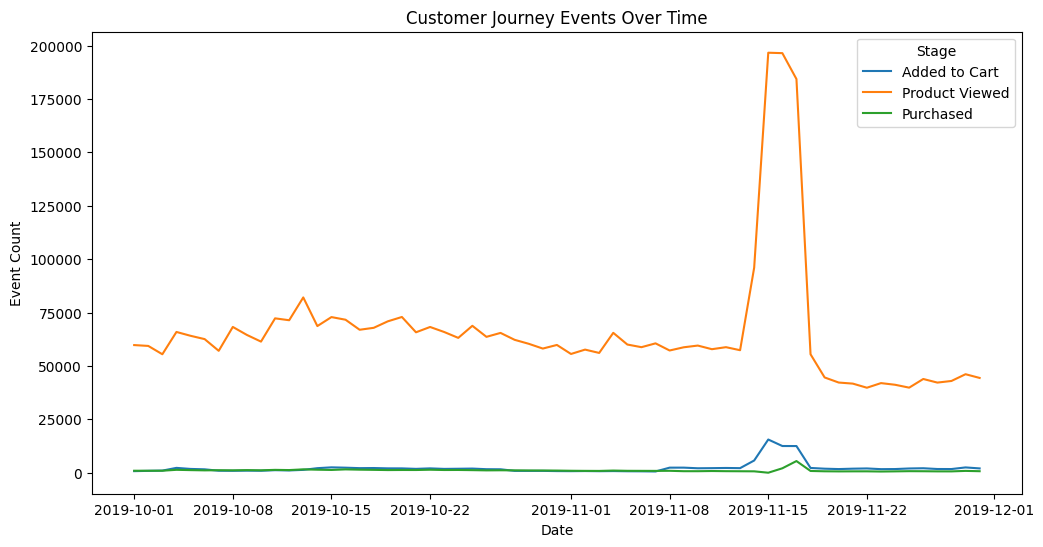

In [ ]:
# Count daily events
df_stages['date'] = df_stages['event_time'].dt.date
daily_events = df_stages.groupby(['date', 'stage']).size().unstack().fillna(0)

# Plot
daily_events.plot(figsize=(12, 6), kind='line')
plt.title('Customer Journey Events Over Time')
plt.ylabel('Event Count')
plt.xlabel('Date')
plt.legend(title='Stage')
plt.show()

In [ ]:
# 2. Print Sample Individual Journeys
sample_journeys = grouped_journeys.sample(10, random_state=1)
for index, row in sample_journeys.iterrows():
    print(f"\nUser {row['user_id']} - Product {row['product_id']}")
    for i, step in enumerate(row['stage'], 1):
        print(f"  Step {i}: {step}")



User 559987065 - Product 26205031
  Step 1: Product Viewed

User 565630592 - Product 1004858
  Step 1: Product Viewed
  Step 2: Product Viewed

User 516174360 - Product 1801963
  Step 1: Product Viewed
  Step 2: Product Viewed
  Step 3: Product Viewed
  Step 4: Product Viewed

User 554501528 - Product 5000216
  Step 1: Product Viewed

User 550167532 - Product 3701392
  Step 1: Product Viewed
  Step 2: Product Viewed

User 558027873 - Product 1004659
  Step 1: Product Viewed
  Step 2: Product Viewed

User 517525414 - Product 26400601
  Step 1: Product Viewed

User 519297271 - Product 1307050
  Step 1: Product Viewed
  Step 2: Product Viewed
  Step 3: Product Viewed
  Step 4: Product Viewed
  Step 5: Product Viewed

User 556890874 - Product 26201166
  Step 1: Product Viewed

User 513180300 - Product 3701491
  Step 1: Product Viewed
  Step 2: Product Viewed


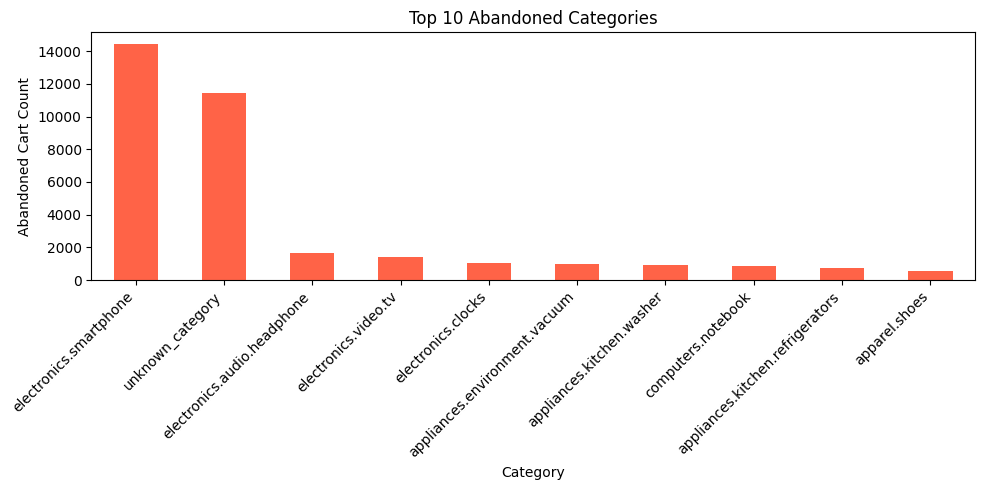

In [ ]:
# Extract latest category_code per (user_id, product_id)
category_lookup = df_combined[['user_id', 'product_id', 'category_code']].dropna().drop_duplicates()
grouped_journeys = grouped_journeys.merge(category_lookup, on=['user_id', 'product_id'], how='left')

def is_abandoned(stages):
    return 'Added to Cart' in stages and 'Purchased' not in stages

grouped_journeys['abandoned'] = grouped_journeys['stage'].apply(is_abandoned)
abandoned_df = grouped_journeys[grouped_journeys['abandoned']]

# Count by category_code instead of product_id
abandoned_counts = abandoned_df['category_code'].value_counts().head(10)

plt.figure(figsize=(10, 5))
abandoned_counts.plot(kind='bar', color='tomato')
plt.title('Top 10 Abandoned Categories')
plt.xlabel('Category')
plt.ylabel('Abandoned Cart Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## A user's journey system - full dataset

In [ ]:
full_df['event_time'] = pd.to_datetime(full_df['event_time'])

# Sort by user and timestamp
df_sorted = full_df.sort_values(by=['user_id', 'event_time'])

# Map event_type to cleaner names (optional but nice)
event_stage_map = {
    'view': 'Product Viewed',
    'cart': 'Added to Cart',
    'purchase': 'Purchased'
}

# Create a new column for stage
df_sorted['stage'] = df_sorted['event_type'].map(event_stage_map)

# Filter only the key events you're analyzing
df_stages = df_sorted[df_sorted['event_type'].isin(['view', 'cart', 'purchase'])]

In [ ]:
# View a sample user's journey
sample_user_id = df_stages['user_id'].iloc[0]  # pick one user ID
user_journey = df_stages[df_stages['user_id'] == sample_user_id]

print(user_journey[['event_time', 'product_id', 'stage']])

In [ ]:
grouped_journeys = df_stages.groupby(['user_id', 'product_id'])['stage'].apply(list).reset_index()

pd.set_option('display.max_colwidth', None)

print(grouped_journeys.head())

# Time Forecasting

## Sampled Data

In [ ]:
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])

# Filter for purchase events only
df_purchases = df_combined[df_combined['event_type'] == 'purchase'].copy()

# Aggregate purchase counts by date
df_purchases['date'] = df_purchases['event_time'].dt.date
daily_purchases = df_purchases.groupby('date').size().reset_index(name='y')
daily_purchases.rename(columns={'date': 'ds'}, inplace=True)

print(daily_purchases.head())

           ds     y
0  2019-10-01   998
1  2019-10-02   984
2  2019-10-03   918
3  2019-10-04  1238
4  2019-10-05  1097


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpszdl48qj/pr3ccmtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpszdl48qj/8ljgy9mv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46252', 'data', 'file=/tmp/tmpszdl48qj/pr3ccmtu.json', 'init=/tmp/tmpszdl48qj/8ljgy9mv.json', 'output', 'file=/tmp/tmpszdl48qj/prophet_model6dt5xkdp/prophet_model-20250413233652.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


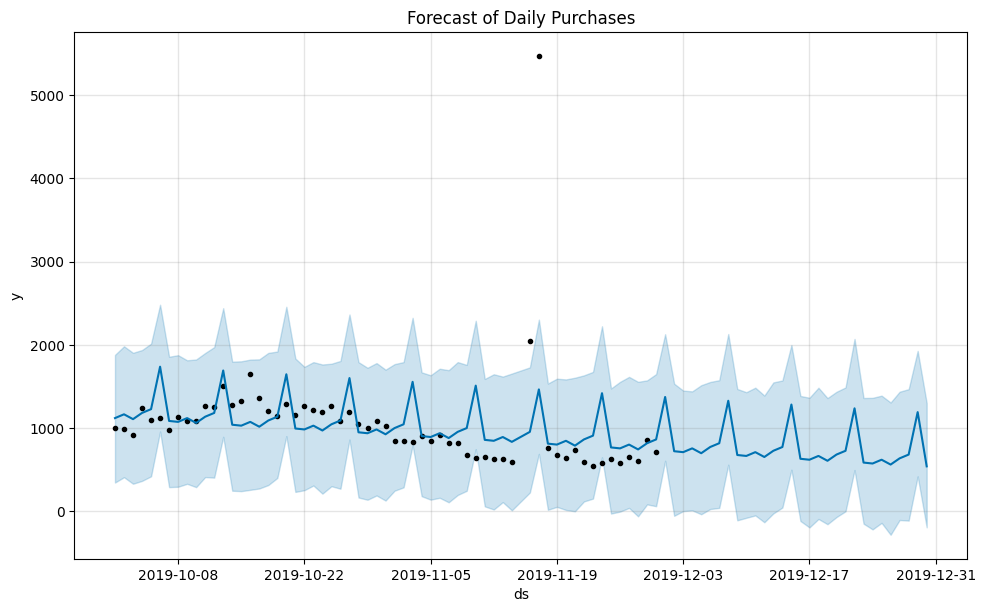

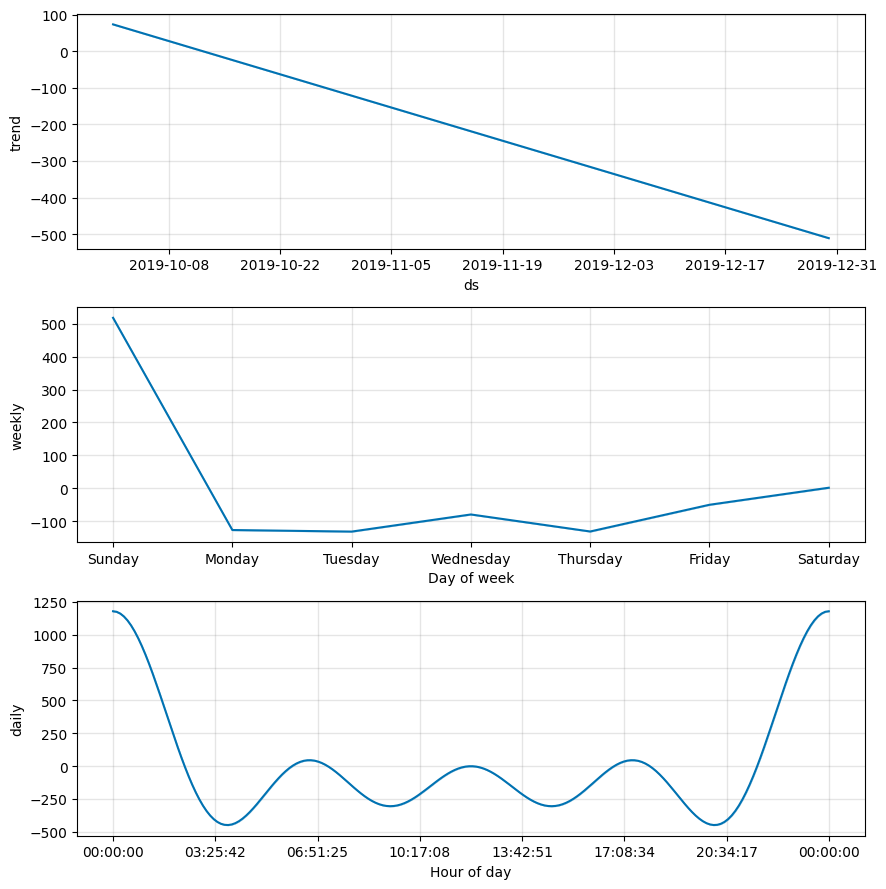

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit the model
model = Prophet(daily_seasonality=True)
model.fit(daily_purchases)

# Forecast the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Forecast of Daily Purchases")
plt.show()

# Decompose trend & seasonality
model.plot_components(forecast)
plt.show()


In [ ]:
# Define holidays
holidays = pd.DataFrame({
    'holiday': ['halloween', 'black_friday', 'cyber_monday', 'christmas'],
    'ds': pd.to_datetime(['2019-10-31', '2019-11-29', '2019-12-02', '2019-12-25']),
    'lower_window': 0,
    'upper_window': 1  # effect can spill into next day
})

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpszdl48qj/g3n7w99w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpszdl48qj/fupge0bc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81700', 'data', 'file=/tmp/tmpszdl48qj/g3n7w99w.json', 'init=/tmp/tmpszdl48qj/fupge0bc.json', 'output', 'file=/tmp/tmpszdl48qj/prophet_modelirz303q7/prophet_model-20250413233841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


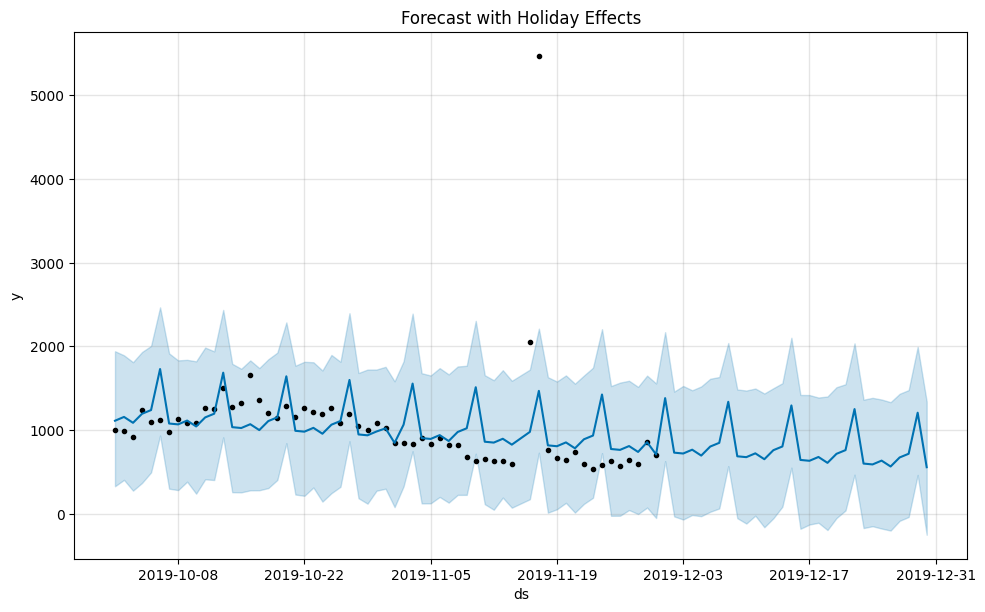

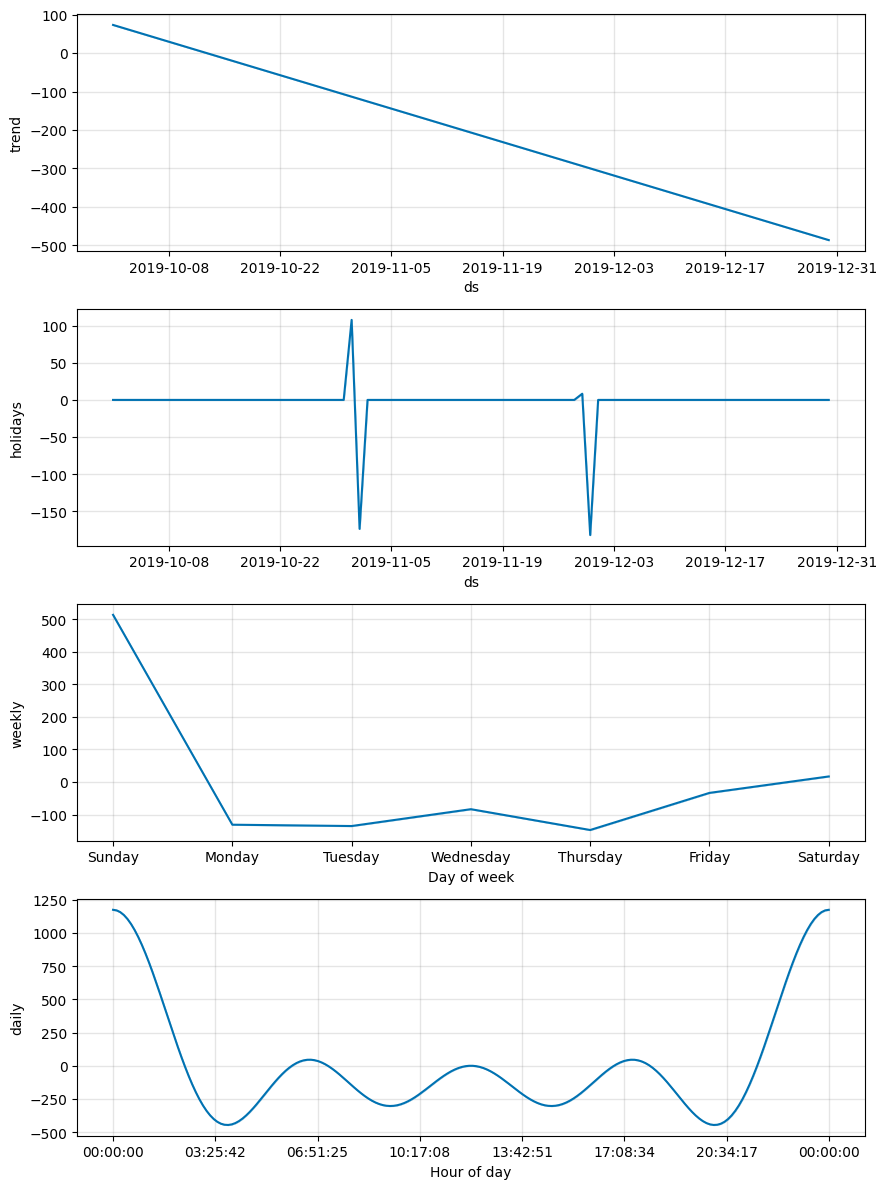

In [ ]:
model = Prophet(daily_seasonality=True, holidays=holidays)
model.fit(daily_purchases)

# Future dataframe (30-day forecast)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title("Forecast with Holiday Effects")
plt.show()

# Show seasonal components
model.plot_components(forecast)
plt.show()


## Full Dataset

In [ ]:
full_df['event_time'] = pd.to_datetime(full_df['event_time'])

# Filter for purchase events only
df_purchases = full_df[full_df['event_type'] == 'purchase'].copy()

# Aggregate purchase counts by date
df_purchases['date'] = df_purchases['event_time'].dt.date
daily_purchases = df_purchases.groupby('date').size().reset_index(name='y')
daily_purchases.rename(columns={'date': 'ds'}, inplace=True)

print(daily_purchases.head())

           ds      y
0  2019-10-01  19307
1  2019-10-02  19469
2  2019-10-03  19255
3  2019-10-04  27041
4  2019-10-05  23494


### Prophet Model

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/w7sinzyj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/bkeyq4dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33622', 'data', 'file=/tmp/tmp0towbby8/w7sinzyj.json', 'init=/tmp/tmp0towbby8/bkeyq4dt.json', 'output', 'file=/tmp/tmp0towbby8/prophet_modelrnteao7z/prophet_model-20250505182204.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


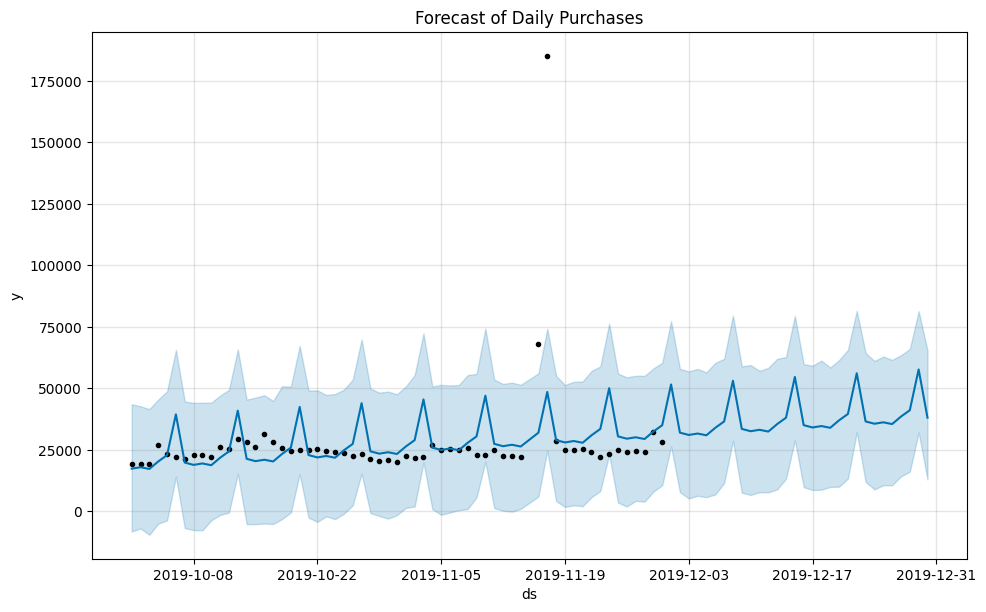

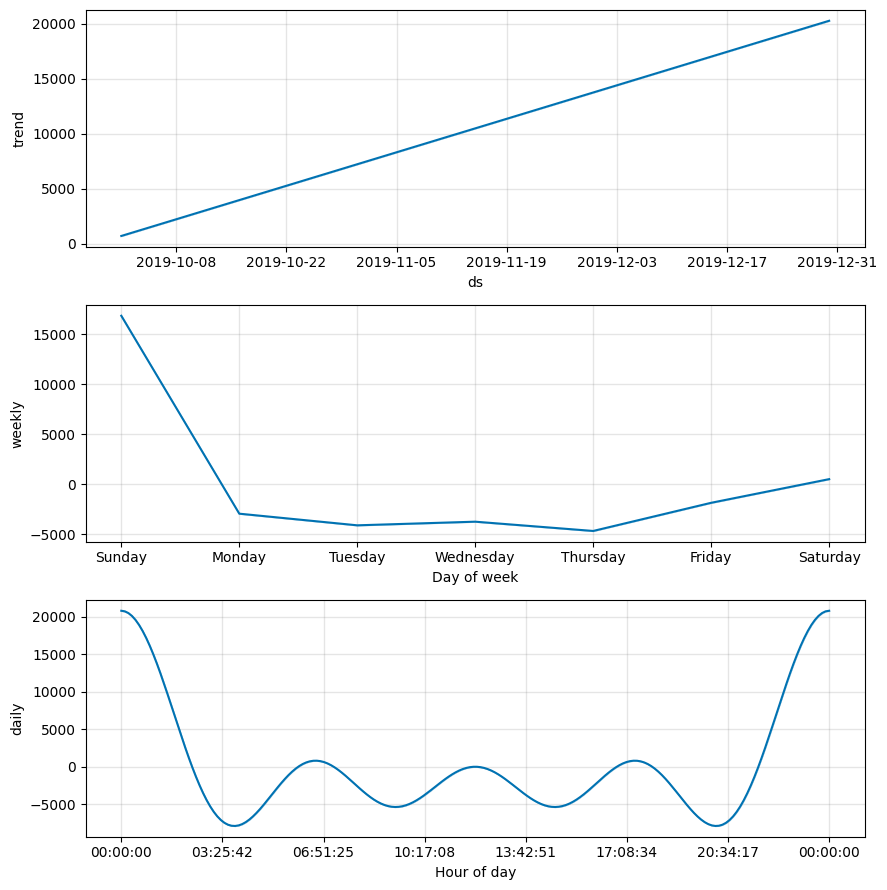

In [ ]:
# Initialize and fit the model
model = Prophet(daily_seasonality=True)
model.fit(daily_purchases)

# Forecast the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Forecast of Daily Purchases")
plt.show()

# Decompose trend & seasonality
model.plot_components(forecast)
plt.show()


In [ ]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
daily_purchases['ds'] = pd.to_datetime(daily_purchases['ds'])

merged = pd.merge(forecast[['ds', 'yhat']], daily_purchases, on='ds', how='left')
merged['residual'] = merged['y'] - merged['yhat']

px.line(merged, x='ds', y='residual', title='Residuals (Actual - Forecast)')

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='30 days', period='15 days', horizon='30 days')

df_p = performance_metrics(df_cv)

print("Performance Metrics:")
print(df_p[['horizon', 'mae', 'rmse', 'mape']].head())

INFO:prophet:Making 1 forecasts with cutoffs between 2019-10-31 00:00:00 and 2019-10-31 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/7g4_ytd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/ccct_sux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62680', 'data', 'file=/tmp/tmp0towbby8/7g4_ytd8.json', 'init=/tmp/tmp0towbby8/ccct_sux.json', 'output', 'file=/tmp/tmp0towbby8/prophet_modely3mm2xga/prophet_model-20250505182906.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance Metrics:
  horizon          mae         rmse      mape
0  2 days   747.319665   956.204464  0.034089
1  3 days  1163.251215  1177.185986  0.052919
2  4 days  4061.876298  5097.098846  0.154975
3  5 days  6559.819931  6585.523236  0.252960
4  6 days  5958.636072  5958.669337  0.237450


In [ ]:
# Make sure 'ds' matches in dtype
forecast['ds'] = pd.to_datetime(forecast['ds'])
daily_purchases['ds'] = pd.to_datetime(daily_purchases['ds'])

# Merge forecast with actual data
merged = pd.merge(forecast[['ds', 'yhat']], daily_purchases, on='ds', how='left')

# Build figure
fig = go.Figure()

# Actual
fig.add_trace(go.Scatter(x=merged['ds'], y=merged['y'],
                         mode='lines', name='Actual Purchases',
                         line=dict(color='blue')))

# Forecast
fig.add_trace(go.Scatter(x=merged['ds'], y=merged['yhat'],
                         mode='lines', name='Forecast (yhat)',
                         line=dict(color='orange')))

# Format
fig.update_layout(title="📊 Actual vs Forecast",
                  xaxis_title="Date", yaxis_title="Purchases or Effect Value",
                  legend_title="Legend")

fig.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyhqdvxk/vibsfml_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyhqdvxk/d77ahe5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28754', 'data', 'file=/tmp/tmpzyhqdvxk/vibsfml_.json', 'init=/tmp/tmpzyhqdvxk/d77ahe5k.json', 'output', 'file=/tmp/tmpzyhqdvxk/prophet_modelefccaw2x/prophet_model-20250414191623.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


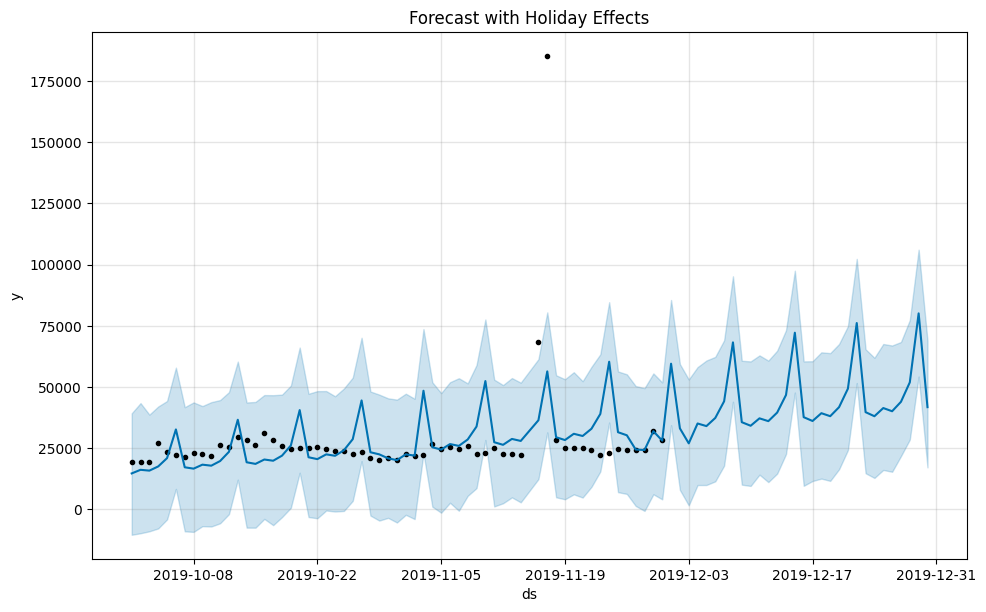

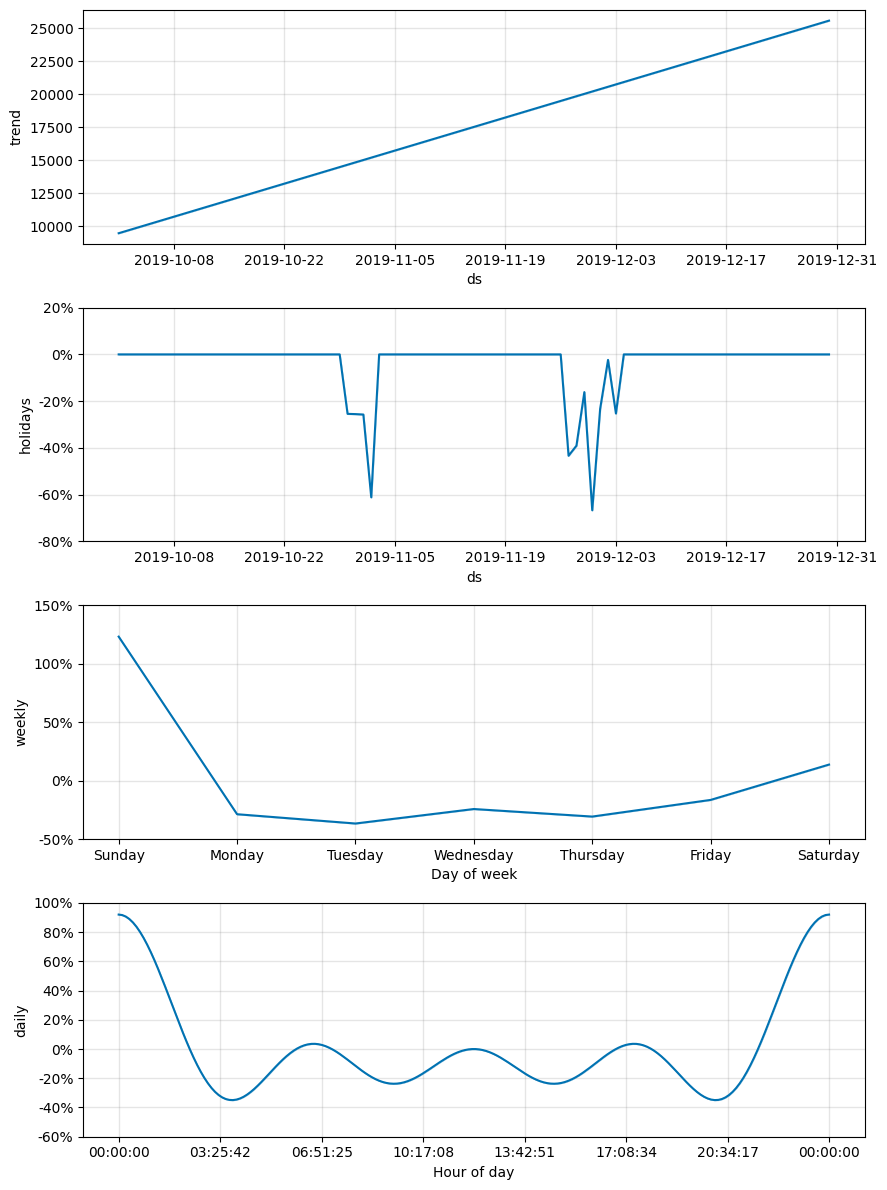

In [ ]:
holidays = pd.DataFrame({
    'holiday': ['halloween', 'black_friday_weekend', 'black_friday_weekend', 'black_friday_weekend', 'black_friday_weekend',
                'cyber_monday', 'cyber_monday',
                'christmas', 'christmas', 'christmas'],
    'ds': pd.to_datetime(['2019-10-31',
                          '2019-11-28', '2019-11-29', '2019-11-30', '2019-12-01',
                          '2019-12-01', '2019-12-02',
                          '2019-12-23', '2019-12-24', '2019-12-25']),
    'lower_window': -1,
    'upper_window': 2

})


model = Prophet(seasonality_mode='multiplicative', daily_seasonality=True, holidays=holidays)
model.fit(daily_purchases)

# Future dataframe (30-day forecast)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title("Forecast with Holiday Effects")
plt.show()

# Show seasonal components
model.plot_components(forecast)
plt.show()

### Investigating Holiday Purchases

In [ ]:
# Ensure your dates are datetime
daily_purchases['ds'] = pd.to_datetime(daily_purchases['ds'])

# Sort to find biggest spikes
top_spikes = daily_purchases.sort_values('y', ascending=False).head(10)
print(top_spikes)

           ds       y
46 2019-11-17  185195
45 2019-11-16   68247
58 2019-11-29   32107
15 2019-10-16   31394
12 2019-10-13   29561
47 2019-11-18   28537
13 2019-10-14   28405
16 2019-10-17   28318
59 2019-11-30   28178
3  2019-10-04   27041


In [ ]:
# Generate strong_holidays from top spikes
strong_holidays = pd.DataFrame({
    'ds': top_spikes['ds'],
    'lower_window': 0,
    'upper_window': 0
})

# Normalize top_spikes['ds'] to date only
strong_holidays['ds'] = pd.to_datetime(strong_holidays['ds']).dt.normalize()

# Normalize your spike_labels keys too
spike_labels = {
    pd.to_datetime('2019-10-31'): 'Halloween',
    pd.to_datetime('2019-11-28'): 'Black Friday Weekend',
    pd.to_datetime('2019-11-29'): 'Black Friday Weekend',
    pd.to_datetime('2019-11-30'): 'Black Friday Weekend',
    pd.to_datetime('2019-12-01'): 'Black Friday Weekend',
    pd.to_datetime('2019-12-02'): 'Cyber Monday',
    pd.to_datetime('2019-12-23'): 'Christmas Week',
    pd.to_datetime('2019-12-24'): 'Christmas Week',
    pd.to_datetime('2019-12-25'): 'Christmas Day'
}
spike_labels = {pd.to_datetime(k).normalize(): v for k, v in spike_labels.items()}

mapped = strong_holidays['ds'].map(spike_labels)
strong_holidays['holiday'] = mapped.where(mapped.notna(),
    ['Custom Spike %d' % i for i in range(len(strong_holidays))]
)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/mvjrfs3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/uylt55p8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22491', 'data', 'file=/tmp/tmp0towbby8/mvjrfs3x.json', 'init=/tmp/tmp0towbby8/uylt55p8.json', 'output', 'file=/tmp/tmp0towbby8/prophet_model2c2uwcnc/prophet_model-20250505183511.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


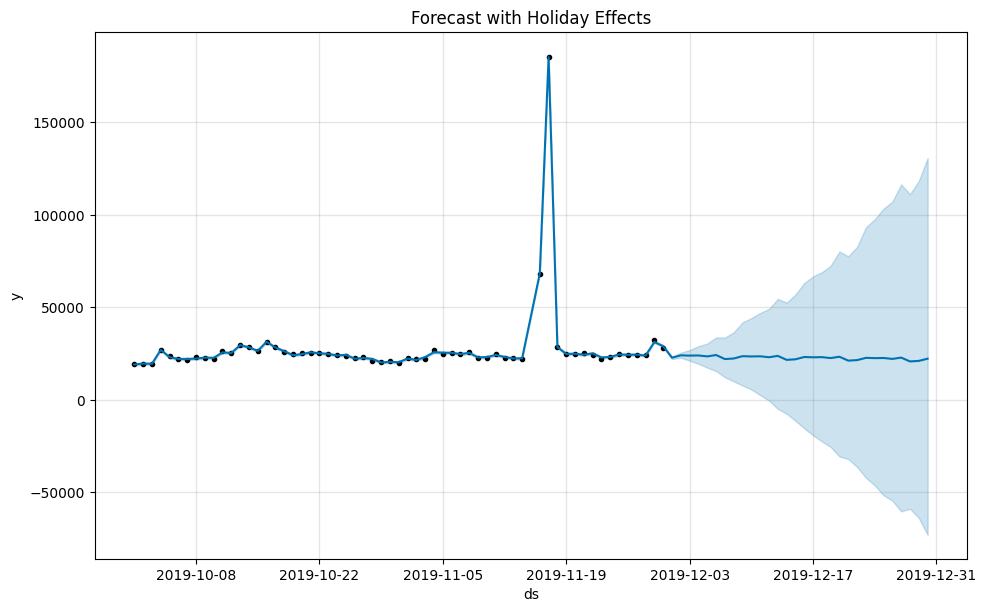

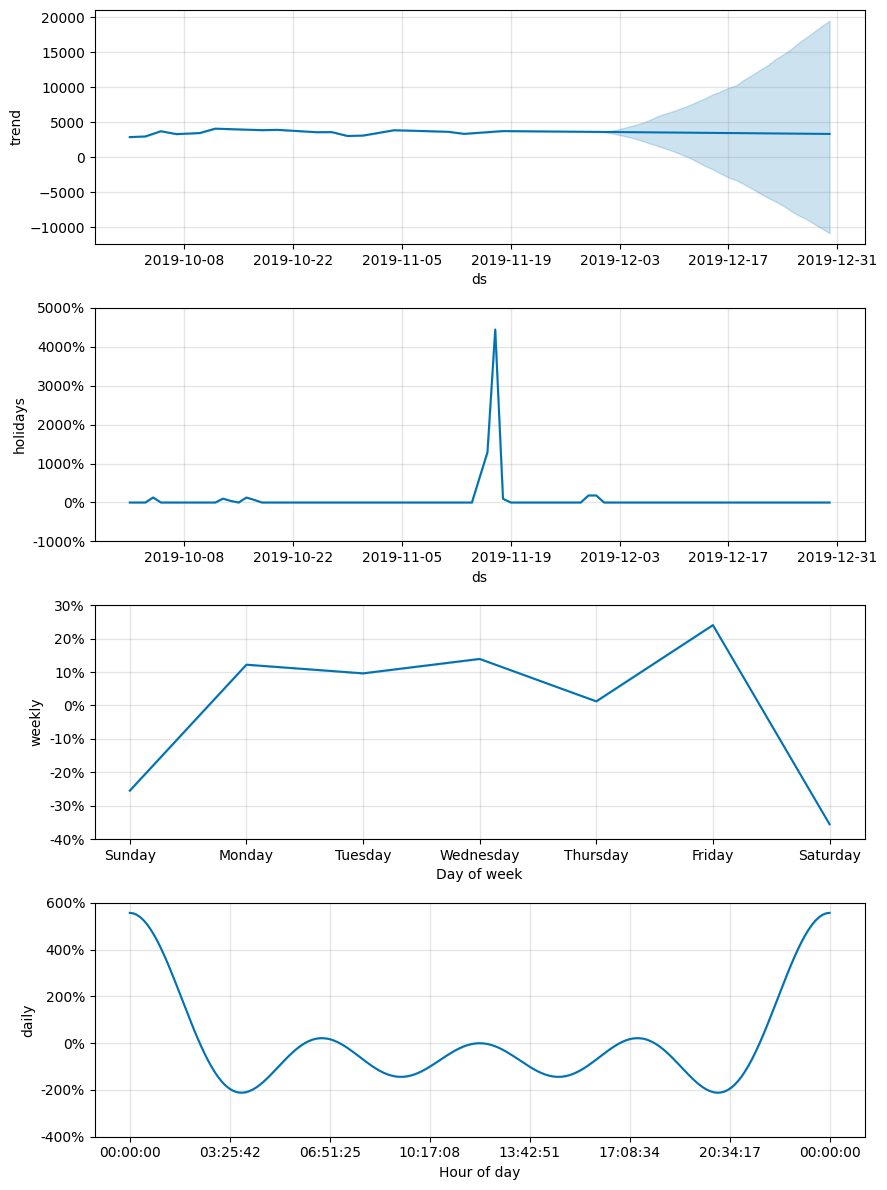

In [ ]:
model = Prophet(holidays=strong_holidays, daily_seasonality=True, seasonality_mode='multiplicative')
model.fit(daily_purchases.assign(floor=0))

forecast = model.predict(model.make_future_dataframe(periods=30))

# Plot
model.plot(forecast)
plt.title("Forecast with Holiday Effects")
plt.show()

# Show seasonal components
model.plot_components(forecast)
plt.show()

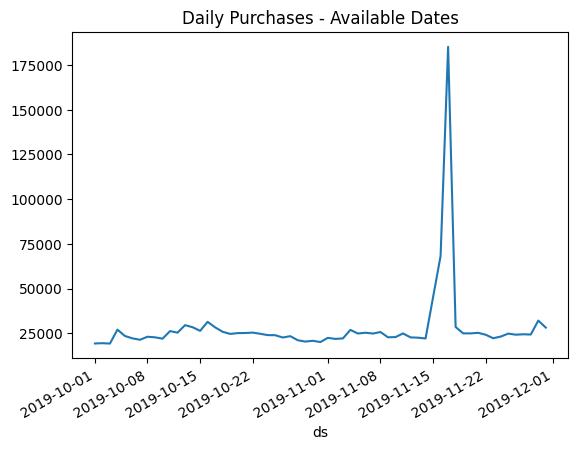

In [ ]:
daily_purchases.set_index('ds')['y'].plot(title="Daily Purchases - Available Dates")
plt.show()

In [ ]:
forecast[['ds', 'holidays']].query('holidays != 0').sort_values('ds')


,ds,holidays
3,2019-10-04,1.290820
12,2019-10-13,0.998308
13,2019-10-14,0.398643
15,2019-10-16,1.272250
16,2019-10-17,0.681776
45,2019-11-16,12.886400
46,2019-11-17,44.391000
47,2019-11-18,0.952126
58,2019-11-29,1.811490
59,2019-11-30,1.811490


In [ ]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
daily_purchases['ds'] = pd.to_datetime(daily_purchases['ds'])

merged = pd.merge(forecast[['ds', 'yhat']], daily_purchases, on='ds', how='left')
merged['residual'] = merged['y'] - merged['yhat']

px.line(merged, x='ds', y='residual', title='Residuals (Actual - Forecast)')


In [ ]:
df_cv = cross_validation(model, initial='30 days', period='15 days', horizon='30 days')

df_p = performance_metrics(df_cv)

print("Performance Metrics:")
print(df_p[['horizon', 'mae', 'rmse', 'mape']].head())

INFO:prophet:Making 1 forecasts with cutoffs between 2019-10-31 00:00:00 and 2019-10-31 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/nib4hnes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0towbby8/ucb75d7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10982', 'data', 'file=/tmp/tmp0towbby8/nib4hnes.json', 'init=/tmp/tmp0towbby8/ucb75d7d.json', 'output', 'file=/tmp/tmp0towbby8/prophet_modeljl07t9ru/prophet_model-20250505183905.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:39:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Performance Metrics:
  horizon          mae         rmse      mape
0  2 days  2790.760728  2804.845122  0.126124
1  3 days  2950.659165  2953.132298  0.134134
2  4 days  6194.425843  7049.216229  0.241643
3  5 days  8902.852780  8927.001268  0.343512
4  6 days  8339.512202  8340.028883  0.332284


In [ ]:
# Make sure 'ds' matches in dtype
forecast['ds'] = pd.to_datetime(forecast['ds'])
daily_purchases['ds'] = pd.to_datetime(daily_purchases['ds'])

# Merge forecast with actual data
merged = pd.merge(forecast[['ds', 'yhat', 'holidays']], daily_purchases, on='ds', how='left')

# Build figure
fig = go.Figure()

# Actual
fig.add_trace(go.Scatter(x=merged['ds'], y=merged['y'],
                         mode='lines', name='Actual Purchases',
                         line=dict(color='blue')))

# Forecast
fig.add_trace(go.Scatter(x=merged['ds'], y=merged['yhat'],
                         mode='lines', name='Forecast (yhat)',
                         line=dict(color='orange')))

# Holiday adjustment
fig.add_trace(go.Scatter(x=merged['ds'], y=merged['holidays'],
                         mode='lines', name='Holiday Effect',
                         line=dict(color='green', dash='dot')))

# Format
fig.update_layout(title="📊 Actual vs Forecast with Holiday Effects",
                  xaxis_title="Date", yaxis_title="Purchases or Effect Value",
                  legend_title="Legend")

fig.show()

In [ ]:
pip install plotly seaborn streamlit prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00
